In [18]:
import ee
import geemap
from geemap import chart

%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWj-IHzxDMcCSGwq26aVV9_FLAvZWhvQn2Ya72C3mkoqKBwUNqkVXME



Successfully saved authorization token.


In [20]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR")

ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
focus = ee.Geometry.Polygon(
        [[[27.350233348102517, -7.518171474050515],
          [27.350233348102517, -7.57841301205225],
          [27.436407359332986, -7.57841301205225],
          [27.436407359332986, -7.518171474050515]]])
WestMine = ee.Geometry.Polygon(
        [[[27.358738291876765, -7.561662590595413],
          [27.36234318079278, -7.564044944105011],
          [27.370411265509578, -7.545155923172768],
          [27.363201487677546, -7.53885939945966],
          [27.35564838709161, -7.542262937167664]]])
EastMine = ee.Geometry.Polygon(
        [[[27.40010868372247, -7.521416293051669],
          [27.400966990607234, -7.534520294117901],
          [27.381225932257625, -7.552729091874256],
          [27.384659159796687, -7.55426063803815],
          [27.40457187952325, -7.542008116801026],
          [27.406975138800593, -7.53877475471045],
          [27.40285526575372, -7.521586477421349]]])
TailingPond = ee.Geometry.MultiPolygon(
        [[[[27.40117714611331, -7.528029420400128],
           [27.40143463817874, -7.529901416251066],
           [27.40237877575198, -7.5338155632667805],
           [27.404009558833035, -7.535347176386731],
           [27.403837897456082, -7.531603223645428],
           [27.402807929194363, -7.53075232078353],
           [27.402464606440457, -7.527518874674277]]],
         [[[27.401692130244168, -7.537219140622778],
           [27.40160629955569, -7.538835830496198],
           [27.402207114375027, -7.539516540215821],
           [27.40564034191409, -7.539091096766489],
           [27.40564034191409, -7.538410386377943]]],
         [[[27.38813088146487, -7.548791103460967],
           [27.38890335766116, -7.549046363857512],
           [27.391821601069363, -7.5484507560311345],
           [27.389761664545926, -7.546749014863657]]]])
MinePile = ee.Geometry.MultiPolygon(
        [[[[27.39990282562306, -7.538976580191123],
           [27.39863682296803, -7.539487112415201],
           [27.398057465820813, -7.54067835192985],
           [27.397799973755383, -7.542380116977695],
           [27.398883584767866, -7.542497115405488],
           [27.4003963520818, -7.542784285193142],
           [27.401705270081067, -7.541890860211821],
           [27.4014048626714, -7.540295453871944],
           [27.400782588904605, -7.539561565404619]]],
         [[[27.40360114464233, -7.528471399345152],
           [27.40287158379028, -7.53102411635294],
           [27.40506026634643, -7.531151751808675],
           [27.40561816582153, -7.528769217103983]]],
         [[[27.400167917103268, -7.535108432289119],
           [27.400554155201412, -7.5369803975571035],
           [27.403300737232662, -7.537108031257986],
           [27.403944467396236, -7.5352360665416755],
           [27.402013276905514, -7.533491728501599]]],
         [[[27.357092737193568, -7.547347692672706],
           [27.357650636668666, -7.550155558119731],
           [27.359431623454554, -7.550389546083809],
           [27.360375761027797, -7.547985845511823],
           [27.35890590547972, -7.545039700922603],
           [27.357500432963832, -7.545135422206587]]]]);
mines = ee.FeatureCollection("users/rishiAgarwal/Congo_Active_Mines")


In [21]:
rgbVis = {
    'min': 8097.96,
    'max': 12128.04,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']
}

vigsVis = {
    'min': 0,
    'max': 2.5,
    'palette': ['white', 'green']
}

ndviVis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'green']
}

ironVis = {
    'min': 0,
    'max': 0.25,
    'palette': ['white', 'gray']
}

clayVis = {
    'min': 0,
    'max': 0.25,
    'palette': ['white', 'brown']
}

ndmiVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue']
}

bsiVis = {
    'min': -0.11390094234742729, 
    'max': 0.12724605991882074, 
    'palette': ['white', '#7a5230']
}
ndbiVis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}
greenNIRVis = {
    'min': -0.3899937702037737,
    'max': -0.03382993411150684,
    'palette': ['white', 'green']
}

In [22]:
def create_median_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = ls8 \
            .filter(ee.Filter.bounds(geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .filter(ee.Filter.lt('CLOUD_COVER', 15)) \
            .select('SR_B.*') \

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

In [23]:
def add_median_composites(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')

    return Map

In [24]:
def create_ndvi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])
        Map.addLayer(ndvi, ndviVis, 'NDVI ' + str(year))
        
    return Map

In [25]:
def create_iron_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        iron = image.normalizedDifference(['SR_B4', 'SR_B2'])
        Map.addLayer(iron, ironVis, 'Iron Concentration ' + str(year))
        
    return Map

In [26]:
def create_clay_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        clay = image.normalizedDifference(['SR_B6', 'SR_B7'])
        Map.addLayer(clay, clayVis, 'Clay Concentration ' + str(year))
        
    return Map

In [27]:
def create_ndmi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        ndmi = image.normalizedDifference(['SR_B5', 'SR_B6'])
        Map.addLayer(ndmi, ndmiVis, 'NDMI ' + str(year))
        
    return Map

In [28]:
def create_vigs_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        g_r = image.normalizedDifference(['SR_B3', 'SR_B4'])
        nir_r = image.normalizedDifference(['SR_B5', 'SR_B4'])
        nir_swir1 = image.normalizedDifference(['SR_B5', 'SR_B6'])
        nir_swir2 = image.normalizedDifference(['SR_B5', 'SR_B7'])
        
        vigs = g_r.add(nir_r.multiply(0.5)) \
            .add(nir_swir1.multiply(1.5)) \
            .add(nir_swir2.multiply(1.5))
        
        Map.addLayer(vigs, vigsVis, 'VIGS ' + str(year))
        
    return Map

In [29]:
def create_bsi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        # BSI
        bsi = image.expression(
            '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
            'X': image.select('SR_B6'), #swir1
            'Y': image.select('SR_B4'),  #red
            'A': image.select('SR_B5'), # nir
            'B': image.select('SR_B2'), # blue
            })

        Map.addLayer(bsi, bsiVis, 'BSI ' + str(year))
        
    return Map

In [30]:
def create_ndbi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    for image, year in images:
        ndbi = image.normalizedDifference(['SR_B6', 'SR_B5'])
        Map.addLayer(ndbi, ndbiVis, 'NDBI ' + str(year))
        
    return Map

In [31]:
def create_greenNIR_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    for image, year in images:
        greenNIR = image.normalizedDifference(['SR_B3', 'SR_B5'])
        Map.addLayer(greenNIR, greenNIRVis, 'greenNIR ' + str(year))
        
    return Map

In [32]:
#HCSI = (B07 − B05)/B04 × (B04/B03)
def create_cd_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        # HCSI
        hcsi = image.expression(
            '((X - Y) / A) * (A / B))', {
            'X': image.select('SR_B6'), #swir1
            'Y': image.select('SR_B4'),  #red
            'A': image.select('SR_B5'), # nir
            'B': image.select('SR_B2'), # blue
            })

        Map.addLayer(bsi, bsiVis, 'BSI ' + str(year))
        
    return Map

<h1>Kanunka Region</h1>

<h3> Median Composites </h3> 

In [33]:
images = create_median_composites(focus, 2014, 2020)
Map = add_median_composites(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> NDVI </h3>

In [34]:
Map = create_ndvi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> NDMI </h3>

In [35]:
Map = create_ndmi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3>Iron</h3>

In [36]:
Map = create_iron_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3>Clay</h3>

In [37]:
Map = create_clay_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> VIGS </h3>

In [38]:
Map = create_vigs_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> BSI </h3>

In [39]:
Map = create_bsi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> NDBI </h3>

In [40]:
Map = create_ndbi_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

<h3> Green NIR Normalized Difference </h3>

In [41]:
Map = create_greenNIR_layers(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

In [65]:
#HCSI = (B07 − B05)/B04 × (B04/B03)



In [26]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 100
    })
    
    properties = {
        'Year': image.get('system:index'),
        'NDVI': stats.get('ndvi'),
        'VIGS': stats.get('vigs'),
        'NDMI': stats.get('ndmi'),
        'BSI': stats.get('bsi'),
        'Iron': stats.get('iron'),
        'Clay': stats.get('clay'),
        'GNIR': stats.get('gNIR')
    }
    
    return ee.Feature(None, properties)

In [27]:
def add_all_bands(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')
    iron = image.normalizedDifference(['SR_B4','SR_B2']).rename('iron')
    clay = image.normalizedDifference(['SR_B6', 'SR_B7']).rename('clay')
    ndmi = image.normalizedDifference(['SR_B5', 'SR_B6']).rename('ndmi')
    gnir = image.normalizedDifference(['SR_B5', 'SR_B3']).rename('gNIR')
    g_r = image.normalizedDifference(['SR_B3', 'SR_B4'])
    nir_r = image.normalizedDifference(['SR_B5', 'SR_B4'])
    nir_swir1 = image.normalizedDifference(['SR_B5', 'SR_B6'])
    nir_swir2 = image.normalizedDifference(['SR_B5', 'SR_B7'])
        
    vigs = g_r.add(nir_r.multiply(0.5)) \
        .add(nir_swir1.multiply(1.5)) \
        .add(nir_swir2.multiply(1.5)).rename('vigs')
    
    bsi = image.expression(
            '(( X + Y ) - (A + B)) /(( X + Y ) + (A + B)) ', {
            'X': image.select('SR_B6'), #swir1
            'Y': image.select('SR_B4'),  #red
            'A': image.select('SR_B5'), # nir
            'B': image.select('SR_B2'), # blue
            }).rename('bsi')
    
    return image.addBands([ndvi, iron, clay, ndmi, gnir, vigs, bsi])

In [35]:
def plotGraph(geometry, title):
    images1 = ee.ImageCollection(create_median_composites(geometry, 2014, 2020))
    with_bands1 = images1.map(add_all_bands)
    data1 = ee.FeatureCollection(with_bands1.map(extract_data))
    df1 = geemap.ee_to_pandas(data1)
    images1 = create_median_composites(geometry, 2014, 2020)
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(9,9)

    xticks = [t[1] for t in images1]
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6], xticks)
    df1.plot(ax=ax,
             title = title,
             xlabel='Year',
             ylabel='Mean Band Value',
             marker='o')
    plt.show()

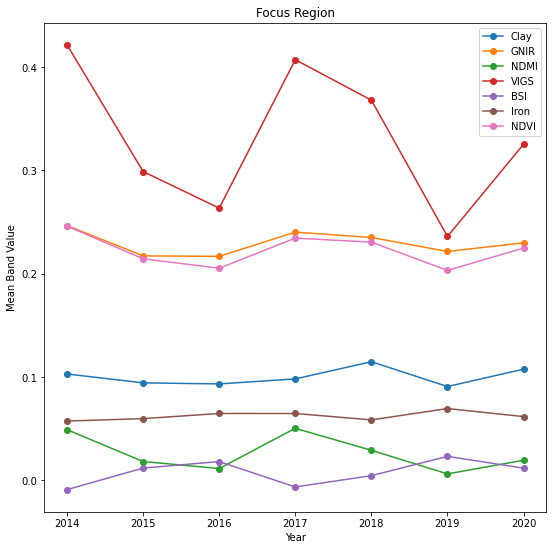

In [36]:
plotGraph(focus, 'Focus Region')

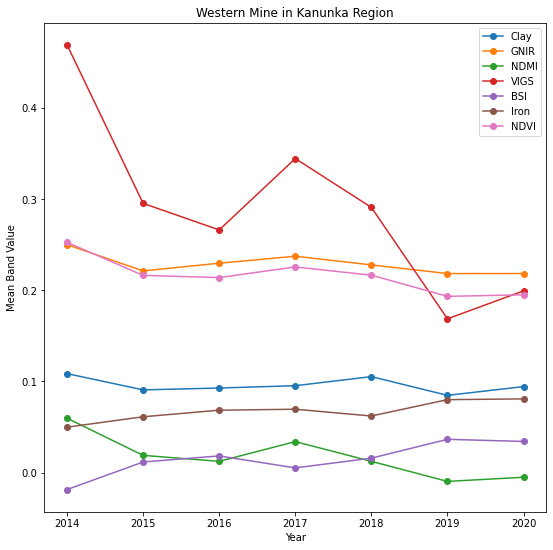

In [37]:
plotGraph(WestMine, "Western Mine in Kanunka Region")

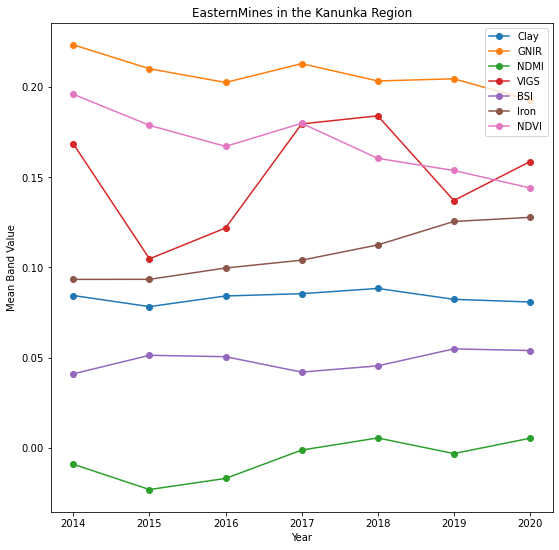

In [38]:
plotGraph(EastMine, "EasternMines in the Kanunka Region")

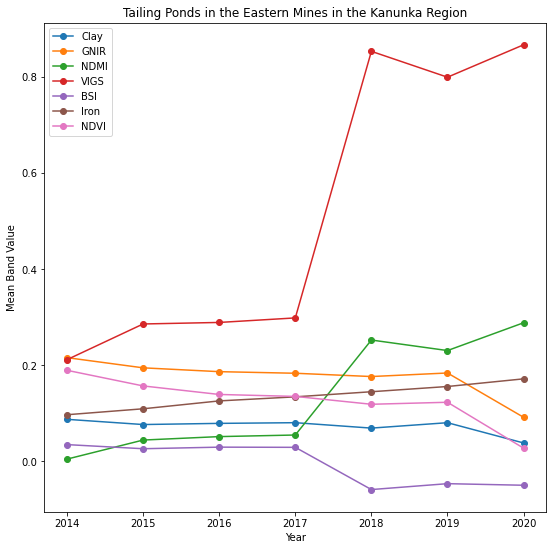

In [39]:
plotGraph(TailingPond, "Tailing Ponds in the Eastern Mines in the Kanunka Region")

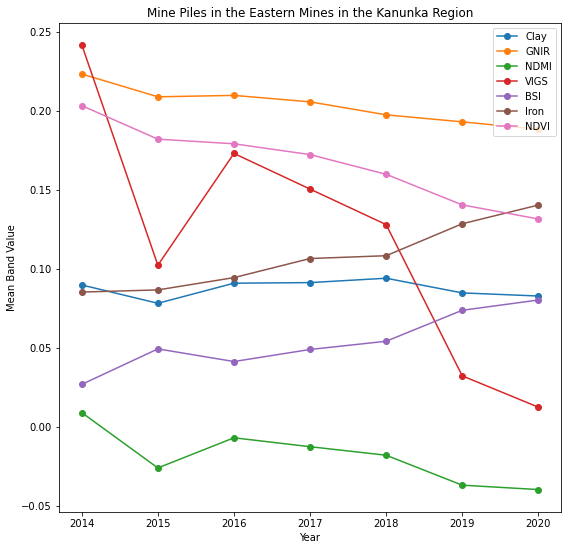

In [40]:
plotGraph(MinePile, "Mine Piles in the Eastern Mines in the Kanunka Region")